## HAPPENN - Fingerprints

## Load data

In [1]:
def load_sequences(file_path):
    sequences = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('>'):
                label = line.strip()[1:].split('|')[7]
                if label == 'hemolytic':
                    labels.append(1)
                elif label == 'non-hemolytic':
                    labels.append(0)
                else:
                    raise ValueError(f"Unknown label: {label}")
            else:
                sequences.append(line.strip())
    return sequences, labels

sequences, labels = load_sequences('data/HAPPENN_dataset.fasta')

In [2]:
from sklearn.model_selection import train_test_split

train_sequences, val_sequences, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42, stratify=labels)

## Convert to molecules

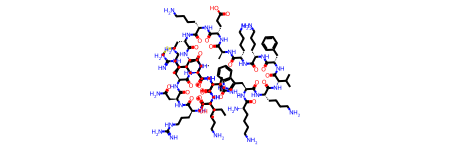

In [3]:
from skfp.preprocessing import MolFromAminoseqTransformer

mol_from_aminoseq = MolFromAminoseqTransformer()

train_mols = mol_from_aminoseq.transform(train_sequences)
val_mols = mol_from_aminoseq.transform(val_sequences)

train_mols[0]

In [4]:
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from skfp.fingerprints import (
    AutocorrFingerprint,
    AtomPairFingerprint,
    AvalonFingerprint,
    E3FPFingerprint,
    ECFPFingerprint,
    ElectroShapeFingerprint,
    ERGFingerprint,
    EStateFingerprint,
    GETAWAYFingerprint,
    FunctionalGroupsFingerprint,
    GhoseCrippenFingerprint,
    KlekotaRothFingerprint,
    LaggnerFingerprint,
    LayeredFingerprint,
    LingoFingerprint,
    MACCSFingerprint,
    MAPFingerprint,
    MHFPFingerprint,
    MordredFingerprint,
    MORSEFingerprint,
    MQNsFingerprint,
    PatternFingerprint,
    PharmacophoreFingerprint,
    PhysiochemicalPropertiesFingerprint,
    PubChemFingerprint,
    RDFFingerprint,
    RDKit2DDescriptorsFingerprint,
    RDKitFingerprint,
    SECFPFingerprint,
    TopologicalTorsionFingerprint,
    USRCATFingerprint,
    USRFingerprint,
    VSAFingerprint,
    WHIMFingerprint,
)

fps = [
    # AutocorrFingerprint,
    # AtomPairFingerprint,
    # AvalonFingerprint,
    # ECFPFingerprint,
        ERGFingerprint,
        EStateFingerprint,
    # FunctionalGroupsFingerprint,
    # GhoseCrippenFingerprint,
    # KlekotaRothFingerprint,
    # LaggnerFingerprint,
    # LayeredFingerprint,
    # LingoFingerprint,
    # MACCSFingerprint,
    # MAPFingerprint,
    # MHFPFingerprint,
    # MordredFingerprint,
        MQNsFingerprint,
    # PatternFingerprint,
    # PharmacophoreFingerprint,
    # PubChemFingerprint,
    # RDKit2DDescriptorsFingerprint,
    # RDKitFingerprint,
        SECFPFingerprint,
        TopologicalTorsionFingerprint,
        VSAFingerprint,
]

names = []
results = []

for Fingerprint in tqdm(fps):
    fp = Fingerprint(n_jobs=-1)
    if fp.requires_conformers:
        raise ValueError(f"{fp.__class__.__name__} requires conformers")
    train_fps = fp.transform(train_mols)
    val_fps = fp.transform(val_mols)
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(train_fps, train_labels)
    y_pred = clf.predict(val_fps)
    names.append(fp.__class__.__name__)
    results.append(accuracy_score(val_labels, y_pred))

100%|██████████| 6/6 [00:23<00:00,  3.94s/it]


In [5]:
import pandas as pd

df = pd.DataFrame({'name': names, 'accuracy': results})
df = df.sort_values(by='accuracy', ascending=False)
df

,name,accuracy
5,VSAFingerprint,0.823529
0,ERGFingerprint,0.820856
1,EStateFingerprint,0.815508
2,MQNsFingerprint,0.802139
3,SECFPFingerprint,0.802139
4,TopologicalTorsionFingerprint,0.800802


The accuracy did not improve but the fingerprints are promising.
Using a union of many fingerprints and a more sophisticated model could improve the accuracy.